### ETAS 1D
- Create a 1D timeseries of expected seismicity rates based on (not-)ETAS


In [1]:
#
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [23]:
-
#
days2sec = 3600.*24.
#
# on a fresh linux install... (can we script this?)
# stuff we have to do besides just clone this:
# pip install geopy
# conda install basemap
# pip install geographiclib
# conda install -c ioos rtree


Using TensorFlow backend.


### Set basic parameters (lat, lon, time bits, etc.)


In [3]:
# event was some time on the 24th or maybe late the 23rd. this, plus defaults, should find the event:
#
Lr_factor = 10.
#
# newest event:
t0 = dtm.datetime(2018, 4, 5, 19, 29, 16, tzinfo=pytz.timezone('UTC'))
to_dt = dtm.datetime.now(pytz.timezone('UTC'))
#to_dt = t0 + dtm.timedelta(days=15)
#
t_ms = t0
#Location
lon0 = -119.726
lat0 = 33.837  
#
m0 = 5.3
d_lat = 4.
d_lon = 4.
#
lats = [lat0-d_lat, lat0+d_lat]
lons = [lon0-d_lon, lon0+d_lon]

In [4]:
class Peak_Filter(list):
    def __init__(self, XY, n_cycles=1, do_upper=True, do_lower=False):
        # TODO: consider a reset-threshold. also consider a similar filter that uses record-breaking
        #  events, maybe also with a reset threshold.
        #
        # A few things:
        #   - for now, always keep the first entry.
        #
        self.__dict__.update({key:val for key,val in locals().items() if not key in ('self', '__class__')})
        #
        super(Peak_Filter, self).__init__(self.calc_peak_sequence())
    #
    def calc_peak_sequence(self, XY=None, n_cycles=None, do_upper=None, do_lower=None):
        if XY is None: XY = self.XY
        n_cycles = n_cycles or self.n_cycles
        if do_upper is None: do_upper = self.do_upper
        if do_lower is None: do_lower = self.do_lower 
        #
        #if n_cycles <= 0: return XY
        #
        # it might be smarter to just use a for-loop, as opposed to this recursive model.
        XY_prime = numpy.array(XY).copy()
        for k in range(n_cycles):
            print('*** DEBUG: {}/{}, len={}'.format(k,n_cycles, len(XY_prime)))
            #
            XY_prime = [XY_prime[0]] + [[x,y] for k, (x,y) in enumerate(XY_prime[1:-1]) 
                                  if (do_upper and (y>XY_prime[k][1] and  y>XY_prime[k+2][1]))
                                    or (do_lower and (y<XY_prime[k][1] and y<XY_prime[k+2][1]))]

        #XY_prime = self.calc_peak_sequence(XY = [XY[0]] + [[x,y] for k, (x,y) in enumerate(XY[1:-1]) 
        #                      if   (do_upper and (x>XY[k][1] and  x>XY[k+2][1]))
        #                        or (do_lower and (x<XY[k][1] and  x<XY[k+2][1]))],
        #                            n_cycles = n_cycles-1, do_upper=do_upper, do_lower=do_lower
        #                            )
        return XY_prime
    @property
    def X(self):
        return numpy.array(self).T[0]
    @property
    def Y(self):
        return numpy.array(self).T[1]
    

In [5]:
# build an ETAS_1d timeseries class. we'll worry about mpp later.
# TODO: code up an interpolated variant, that computes estimated rates between events.
#
class ETAS_1D(list):
    # inherit from list(); populate as [[t,dt], ...] or [[t,rate], ...]
    #
    def __init__(self, catalog=None, lats=None, lons=None, mc=2.5, mc_etas=None, d_lon=.1, d_lat=.1, bin_lon0=0.,
                 bin_lat0=0., t_0=dtm.datetime(1990,1,1, tzinfo=tz_utc), t_now=dtm.datetime.now(tzutc),
                 cat_len=10.*365., etas_fit_factor=1.0,
                 calc_etas=True, n_contours=15, cmap_contours='jet', etas_cat_range=None, etas_xyz_range=None,
                 p_cat=1.1, q_cat=1.5, ab_ratio_expon=.25, p_etas=None, D_fract=1.5, n_cpu=None, **kwargs):
        '''
        #
        #  basically: if we are given a catalog, use it. try to extract mc, etc. data from catalog if it's not
        # externally provided. otherwise, get a catalog from ANSS or OH based oon the parameters provided.
        # note: we want to do this properly in an x-y projection, not lat-lon. our earthquakes will come back to us with lat/lon coordinates
        # so we'll need to translate. we'll also want lat/lon as well as x/y positions for the lattice sites, so we can get even spacing and accurate distances
        #
        # etas_cat_range: range of catalog to do ETAS. mainly, this is to facilitate MPP processing; each process will have a full catalog of earthquakes and
        # (nominally) a full array of etas lattice sites (though we might be able to improve upon this requirement later -- probably the best appraoch is to
        # accept this limitation and write a make_etas() that uses an mpp.Array() object (simplified script).
        #
        # p_,q_cat: p,q values passed to the catalog getter. these will affect not only the p,q values in the catalog, but the
        # other calculated ETAS parameters.
        #
        # p_etas: use this to control p for etas calculations, separate for p calculated in catalog (aka, p to solve initial rates). use p_etas to make time-independent maps.
        '''
        print("begin globalETAS.__init()__")
        # dx=1., dy=1., x0=0., y0=0., leaf_type=float)
        # load all the input parameters into class variables (note i believe locals() is all currently defined variables in the function scope,
        # so this behaves differently if we execute now or down-stream. if we really only want to record the input values, then
        # execute now. if we want to record corrected inputs, then execute after corrections; if we execute at the end, every declared
        # variable becomes a class member.
        #self.__dict__.update(locals())
        #
        # we might just want the last N days, as a consistent standard. note we might, later on, make this a bit more sophisticated
        # by processing the full t_0 -> t_now catalog, but only doing ETAS for the most recent cat_len days. BUT, to do this, we have
        # to enforce in all the do_ETAS() functions
        n_cpu = n_cpu or mpp.cpu_count()
        #
        t_now = (t_now or dtm.datetime.now(pytz.timezone('UTC')))
        if cat_len is not None:
            t_0=t_now - dtm.timedelta(days=cat_len)
            print("Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (%f) = %s" % (cat_len, t_0))
        #
        if lats is None and catalog is None: lats = [-89.9, 89.9]
        if lons is None and catalog is None: lons = [-180., 180.]
        #
        # for now, assume the catalog is string-indexed -- aka, recarray, PANDAS,etc.
        if lats is None and not (catalog is None or len(catalog) is 0): lats = [min(catalog['lat']), max(catalog['lat'])]
        if lons is None and not (catalog is None or len(catalog) is 0): lons = [min(catalog['lon']), max(catalog['lon'])]
        if mc   is None and not (catalog is None or len(catalog) is 0): mc = min(catalog['mag'])
        #
        # and handle some specific cases...
        if isinstance(t_now, float):
            self.t_forecast = t_now
        elif isinstance(t_now, numpy.datetime64):
            self.t_forecast = mpd.date2num(t_now.tolist())
        else:
            self.t_forecast = mpd.date2num(t_now)
        #
        if mc_etas is None: mc_etas = mc  # mc_eats: minimum mag. for etas calculations -- aka, mc for the catalog, but only do etas for m>mc_eatas.
        #
        # inputs massaged; now update class dictionary.
        self.__dict__.update({key:val for key,val in locals().items()})
        #
        self.latses = numpy.arange(lats[0], lats[1], d_lat)        # note: if we want lats[1], lons[1] inclusive, we need to add +d_lat, +d_lon
        self.lonses = numpy.arange(lons[0], lons[1], d_lon)        # to the range().
        self.n_lat = len(self.latses)
        self.n_lon = len(self.lonses)
        #
        # calculate xyz_range (for mpp applications where we split up the geo-spatial array to processes):
        if etas_xyz_range is None: etas_xyz_range = [0,self.n_lat*self.n_lon]
        if etas_xyz_range[0] is None: etas_xyz_range[0] = 0
        if etas_xyz_range[1] is None: etas_xyz_range[1] = self.n_lat*self.n_lon 
        #etas_xyz_range[0] = (etas_xyz_range[0] or 0)
        #etas_xyz_range[1] = (etas_xyz_range[1] or self.n_lat*self.n_lon)
        #
        # construct ETAS xyz, array... but do we use this in the 1D system?
        #ETAS_array = numpy.array([])
        ## [etas_xyz_range[0]:etas_xyz_range[1]]
        #ETAS_array = numpy.array([[lon, lat, 0.] for j, (lat,lon) in 
        #                        enumerate(itertools.product(self.latses, self.lonses)) 
        #                          if (j>= etas_xyz_range[0] and j<etas_xyz_range[1])])
        #ETAS_array = numpy.core.records.fromarrays(zip(*self.ETAS_array), 
        #                                           dtype = [('x', '>f8'), ('y', '>f8'), ('z', '>f8')])
        #
        if catalog is None:
            # TODO: does this use comcat?
            print("fetch and process catalog for dates: {}".format([t_0, t_now]))
            #catalog = make_ETAS_catalog(incat=None, lats=lats, lons=lons, mc=mc, date_range=[t_0, t_now], fit_factor=etas_fit_factor)    # and note there are other variables to consider...
            catalog = gep.make_ETAS_catalog_mpp(incat=None, lats=lats, lons=lons, mc=mc, date_range=[t_0, t_now],
                                fit_factor=etas_fit_factor, p=p_cat, q=q_cat, D_fract=D_fract) 
            print("catalog fetched and processed.")
        catalog = catalog[catalog['mag']>mc]
        #self.catalog = catalog
        #
        self.__dict__.update({key:val for key,val in locals().items() if not key in ('self', '__class__')})
        #
        # set the ETAS rates, and use the self.set_ETAS_rates() default behavior, so we can modify this in
        #  in sub-classes.
        self.set_ETAS_rates()
        #
    #
    @property
    def X(self):
        #return numpy.array(self).T[0]
        return numpy.array(self)[:,0]
    @property
    def rates_pre(self):
        #return numpy.array(self).T[1]
        return numpy.array(self)[:,1]
    @property
    def rates_post(self):
        #return numpy.array(self).T[2]
        return numpy.array(self)[:,2]
    @property
    def intervals_pre(self):
        return 1./self.rates_pre
    @property
    def intervals_post(self):
        return 1./self.rates_post
    @property
    def mags(self):
        return self.catalog['mag']
    #
    def set_ETAS_rates(self, catalog=None, k_start=0, k_skip=1, n_cpu=None):
        super(ETAS_1D, self).__init__(self.compute_ETAS_rates(catalog=catalog, k_start=k_start,
                                                             k_skip=k_skip, n_cpu=n_cpu))
        #
    #
    def compute_ETAS_rates(self, catalog=None, quakes=None, k_start=0, k_skip=1, n_cpu=None):
        '''
        # compute and return ETAS-smoothed seismicity rates.
        '''
        # TODO: mpp this. pass a full copy of the catalog to each process; for each process, start at 
        #   k_proc, and skip by k_procs, so for j,rw in enumerate(catalog)[k::k]:
        #    (or something like that), then return and aggregate.
        #
        # TODO: do we want to figure out a workflow to assign the quakes[] array to the class scope (and
        #   keep it)?
        #
        n_cpu = n_cpu or self.n_cpu
        n_cpu = n_cpu or mpp.cpu_count()
        #m3
        
        if quakes is None:
            if catalog is None: catalog = self.catalog
            quakes = [gep.Earthquake(eq) for eq in catalog]

        #print('*** DEBUG: len(catalog):: ', len(catalog))
        if n_cpu > 1:
            # TODO: check this (mpp.Pool(),etc.) syntax)
            # mpp subsets to this function with n_cpu=1; return, concatenate, sort.
            P = mpp.Pool(n_cpu)
            results = [P.apply_async(self.compute_ETAS_rates, kwds={'catalog':None, 'quakes':quakes, 'k_start':k, 
                                                'k_skip':k_skip*n_cpu, 'n_cpu':1}) for k in range(n_cpu)]
            P.close()
            P.join()
            #
            # NOTE this syntax:
            # pool_results = functools.reduce(numpy.append, [pr for pr in pool_results if not pr is None]
            rates = []
            for r in results:
                rates += r.get()
            rates.sort(key=lambda rw:rw[0])
            return rates
        #
        #quakes = []
        rates  = []
        #for k,eq in enumerate(catalog)[k_start::k_skip]:
        #for k,eq in zip(range(k_start,len(catalog),k_skip), catalog[k_start::k_skip]):
        #print('***DEBUG: ', k_start, k_skip, len(catalog))
        #for k,eq in catalog[k_start::k_skip]:
        #
        # TODO: wrap this up to just return a single list-comprehension.
        for k, eq in enumerate(quakes[k_start::k_skip]):
            #quakes += [gep.Earthquake(eq)]
            # f***ing date types... numpy.datetime64.astype(float) returns some sort of Unix-like float, probably
            #   in seconds, whereas we have been operating on a different (Python.datetime, matplotlib.dates, etc.
            #   float-in-days standard. obviously, the translation is easy to find, but for now, let's just use
            #   the below conversion to get what we want. we should probably code a "standard_dates_to_float()"
            #   function into gep, to hopefully simplify the process. we solve for a linear conversion model; we get
            #   a ~ 0, b ~ 4.9e-10
            # (a,b) = [  3.22251660e-25   4.83764153e-10]... so maybe milliseconds?
            #
            #
            #t = eq['event_date'].astype(float)
            #t = mpd.date2num(eq['event_date'].astype(dtm.datetime))
            t = mpd.date2num(eq.event_date.astype(dtm.datetime))
            #
            #
            # TODO: .omori_rate(t), i believe, returns a rate in eq/s, not eq/day, which is probably what 
            #  we are calculating in the other sequences. be sure to pass the correct mc to Earthquake()...
            # orate = 1./(self.tau * (self.t_0 + delta_t)**p)
            #
            # compute the cumulative ETAS rates at time=t just before the last event (aka, excluding
            #  the current event, and then including that event (and note the +1-1 syntax is meant to
            #   illustrate that this is what we are doing.)
            #rates += [[t, numpy.sum([q.omori_rate(t) for q in quakes[0:k_start + k*k_skip+1]])]]
            rates += [[t, numpy.sum([q.omori_rate(t)*days2sec for q in quakes[0:k_start + k*k_skip+1-1]])]]
            rates[-1] += [eq.omori_rate(t)*days2sec]
            
            # use this for debugging to see that quakes is being properly sampled:
            #rates += [[t, numpy.sum([q.omori_rate(t) for q in quakes]), len(quakes)]]
        #
        # TODO: this computes the first "pre" rate = 0, which is a problem, particularly for intervals.
        #  for now, assume this is always/only the first pre- rate, so just fix it for now... obviously,
        #  we should be smarter about how we compute this, and how we correct it (can we get multiple 0
        #  rates? what about mid-sequence 0 rates, etc.)
        #
        if rates[0][1]==0: rates[0][1] = rates[1][1]
        #
        return rates
    #
    def plot_intervals_and_mags(self, ax=None, fg=None, m0=5.5, alpha=.7, zorder=5, clr_eq='r',  **kwargs):
        #
        # TODOL parse this out a bit more. separate the rates and magnitudes plots, then write a wrapper
        #  that stacks them (what this script does)
        if ax is None:
            if fg is None:
                fg = plt.figure(figsize=(14,9))
            elif isinstance(fg, int) or isinstance(fg, float):
                fg = plt.figure(int(fg))
            #
            # now, make this figure active via the fg.number (fignum) property:
            plt.figure(fg.number)
            #
            ax = plt.subplot('111')
        ax1a = ax1.twinx()
        ax.set_title('intervals_GR')
        
        #
        # TODO: need some pre-smoothing before Kalman. maybe a peaks (HH type) filter?
        #K_intervals = kalman_filters.Kalman_Filter(intervals_0)
        #
        print('intervals_GR:')
        ax.plot(self.X, self.intervals_pre, ls='-', marker='', alpha=alpha, zorder=zorder, **kwargs)
        
        #m0 = 5.5
        t_m0, m_m0 = numpy.array([(t,m) for t,m in zip(self.X, self.mags) if m>=m0]).T
        #print('*** DEBUG: ', t_m0[0:5], m_m0[0:5])
        ax1a.vlines(t_m0, ymin=2., ymax=m_m0, colors='r', lw=2., alpha=.7)
        ax1a.plot(self.X[0::len(self.X)-1], [m0,m0], color=clr_eq, ls='--', alpha=.5, lw=2.0)

    

In [6]:
t1 = time.time()
print('time start: {}'.format(t1))
etas = ETAS_1D(lats=lats, lons=lons, cat_len=None, mc=3.5, n_cpu=None)
catalog = etas.catalog.copy()
#
t2 = time.time()
print('time elapsed: {}'.format(t2-t1))


time start: 1558389109.3046632
begin globalETAS.__init()__
fetch and process catalog for dates: [datetime.datetime(1990, 1, 1, 0, 0, tzinfo=<UTC>), datetime.datetime(2019, 5, 20, 21, 51, 49, 283971, tzinfo=<UTC>)]
etas_prams:  {'do_recarray': False, 'b2': 1.5, 'b1': 1.0, 'dmstar': 1.0, 'q': 1.5, 'p': 1.1, 'fit_factor': 1.0, 'd_tau': 2.28, 'd_lambda': 1.76, 'D_fract': 1.5, 'date_range': [datetime.datetime(1990, 1, 1, 0, 0, tzinfo=<UTC>), datetime.datetime(2019, 5, 20, 21, 51, 49, 283971, tzinfo=<UTC>)], 'mc': 3.5, 'lons': [-123.726, -115.726], 'lats': [29.837000000000003, 37.837], 'incat': None}
results fetched.
catalog fetched and processed.
time elapsed: 108.8815906047821


In [7]:
#%time etas2a = ETAS_1D(catalog=catalog.copy(), lats=lats, lons=lons, cat_len=None, n_cpu=4)
#%time etas2b = ETAS_1D(catalog=catalog.copy(), lats=lats, lons=lons, cat_len=None, n_cpu=1)
etas_mc35 = ETAS_1D(catalog=catalog.copy(), lats=lats, lons=lons, mc=3.5, cat_len=None, n_cpu=None)
print('lens: ', len(etas), len(etas_mc35))
#
# print(etas_mc35.rates_pre[0:5])
# print(etas_mc35.rates_post[0:5])

begin globalETAS.__init()__
lens:  2822 2822


No handles with labels found to put in legend.
No handles with labels found to put in legend.


intervals_GR:
intervals_GR:


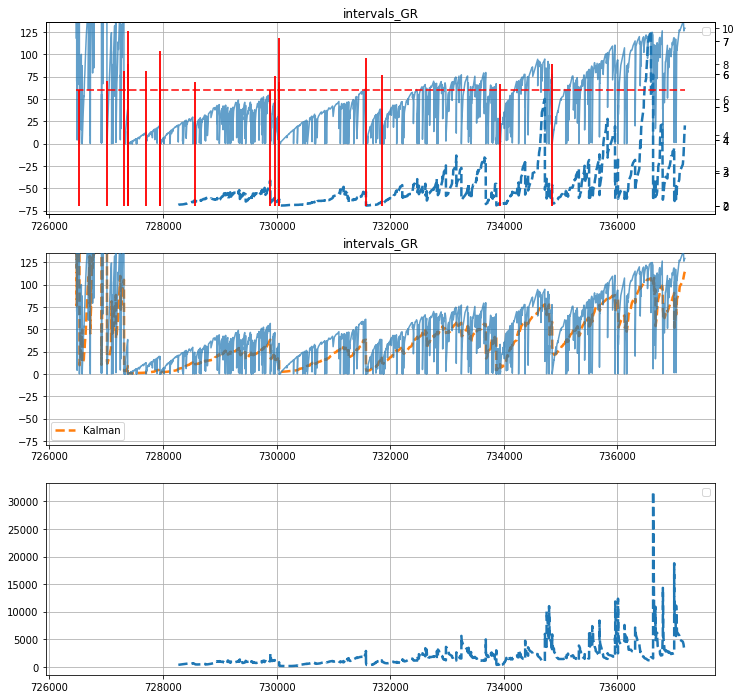

In [8]:
fg = plt.figure(figsize=(12,12))
ax1 = plt.subplot('311')
ax2 = plt.subplot('312', sharex=ax1)
ax3 = plt.subplot('313', sharex=ax1)
ax3a = ax1.twinx()
#ax.set_yscale('log')
#
ax1.grid()
ax2.grid()
ax3.grid()
#
etas.plot_intervals_and_mags(ax=ax1) #, zorder=5, alpha=.4)
etas_mc35.plot_intervals_and_mags(ax=ax2) #, zorder=5, alpha=.4)
#
ax1.set_ylim(None, max(etas.intervals_pre[-int(.25*len(etas.rates_pre)):]))
ax2.set_ylim(None, max(etas_mc35.intervals_pre[-int(.25*len(etas_mc35.rates_pre)):]))
#
ints_sm = yodiipy.kalman_filters.Kalman_Filter(etas_mc35.intervals_pre, var_ba_factor=10.)
ax2.plot(etas_mc35.X, ints_sm.xs, ls='--', lw=2.5, label='Kalman')
#
n=1000
#ax3.plot(etas_mc35.X[n+1:], numpy.diff(ints_sm.xs)[n:], ls='--', lw=2.5)
ax3.plot(etas_mc35.X[n+1:], ints_sm.vars[n+1:], ls='--', lw=2.5)
#
ax3a.plot(etas_mc35.X[n+1:], 1./(ints_sm.vars[n+1:]/(ints_sm.xs[n+1:]**2.)), ls='--', lw=2.5)
#ax3.set_ylim(-10.,10.)
#
for ax in (ax1, ax2, ax3):
    ax.legend(loc=0)

In [9]:
# print('** ', etas.catalog[0])
# print('** ', etas.catalog.dtype.names)
# #

print(ints_sm.xs[0:10])

print(ints_sm.Zs[0:10])

print(etas_mc35.intervals_pre[0:10])

[ 278.1640692   278.1640692   907.46434594  593.26123806  355.88100744
   76.38195379  170.18428245  209.88384771  130.79406651  297.5970436 ]
[  118.41497574   437.91316266  1581.9253996    593.14766935   118.41497574
    69.88293147   266.16539776   234.25845663     4.10976053   341.1786149 ]
[  118.41497574   437.91316266  1581.9253996    593.14766935   118.41497574
    69.88293147   266.16539776   234.25845663     4.10976053   341.1786149 ]


In [10]:
if False:
    plt.figure(figsize=(12,8))
    ax1 = plt.subplot('211')
    ax2 = plt.subplot('212')
    ax1.plot(*numpy.array(etas2a).T[0:2], zorder=5)
    ax1.plot(*numpy.array(etas2a).T[0:3:2], zorder=5)

    ax1.set_yscale('log')
    #
    # what are we looking for here? errors between different instantiations of ETAS1D?
    #  i think we abandoned this.

    #ax2.plot(*numpy.array(etas2b).T[0:2])
    ax2.plot([rw[0] for rw in etas2a], [etas2a[k][1]-etas2b[k][1] for k,rw in enumerate(etas2a)])

    # looking for exceptions:
    print('exceptions: ')
    for x in [etas2a[k][1]-etas2b[k][1] for k,rw in enumerate(etas2a)]:
        if not x==0.: print('not zero: ', x, etas2a[k][1], 
                            etas2b[k][1])
    print('*** end exceptions')
    #


    plt.figure(figsize=(12,8))
    ax1 = plt.subplot('211')
    ax2 = plt.subplot('212')
    ax2a = ax2.twinx()
    ax1.plot(*numpy.array(etas2a).T[0:2], zorder=5)
    ax1.plot(*numpy.array(etas2a).T[0:3:2], zorder=5)
    #
    Y = numpy.array(etas2a).T[1]-numpy.array(etas2a).T[2]
    ax2.plot(ts[250:], Y[250:])

    ax1.set_yscale('log')
    #ax2.set_ylim(None, 1.1*max(Y[-int(.25*len(Y)):]))
    ax2a.vlines(*zip(*[(t,2, m) for t,m in zip(ts, etas.catalog['mag']) if m>5]), color='r', lw=2.)
    #ax2.set_yscale('log')

In [11]:
#
rates = numpy.array(etas)
#
ts = rates.T[0]
# rates_1   = 1.0/numpy.diff(ts)
# rates_10  = 1.0/numpy.array([(t2-t1)/10. for t1,t2 in zip(ts[0:-10], ts[10:])])
# rates_100 = 1.0/numpy.array([(t2-t1)/100. for t1,t2 in zip(ts[0:-100], ts[100:])])
#
intervals_0 = 1./rates.T[1]
#
#
# let's also look at a simper sequence, like the sigma() metric, based on GR scaling.
m0 = 3.0
n=1
n_grs = [10.**(m-m0) for m in etas.catalog['mag']]

#
z0 = max(rates.T[1])
#ax1.set_ylim(-.1*z0, 1.5*z0)

/home/myoder/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in true_divide


etas rates: 
[[  7.26469410e+05   8.44487780e-03   3.63558734e+05]
 [  7.26470496e+05   2.28355776e-03   3.76334975e+05]
 [  7.26475878e+05   6.32141061e-04   3.55283126e+05]
 [  7.26478057e+05   1.68592081e-03   3.15433573e+05]
 [  7.26478965e+05   8.44487780e-03   3.49870975e+05]
 [  7.26479382e+05   1.43096458e-02   2.82211419e+05]
 [  7.26484977e+05   3.75706237e-03   3.73457554e+05]
 [  7.26486509e+05   4.26878933e-03   3.55283126e+05]
 [  7.26486527e+05   2.43323180e-01   3.26518592e+05]
 [  7.26492586e+05   2.93101606e-03   3.29034357e+05]]

mean_rates_10: 
[ 0.29739687  0.2918545   0.33654794  0.31232297  0.26527138  0.22097305
  0.23876597  0.24703837  0.24693198  0.28999854]
2822 2822


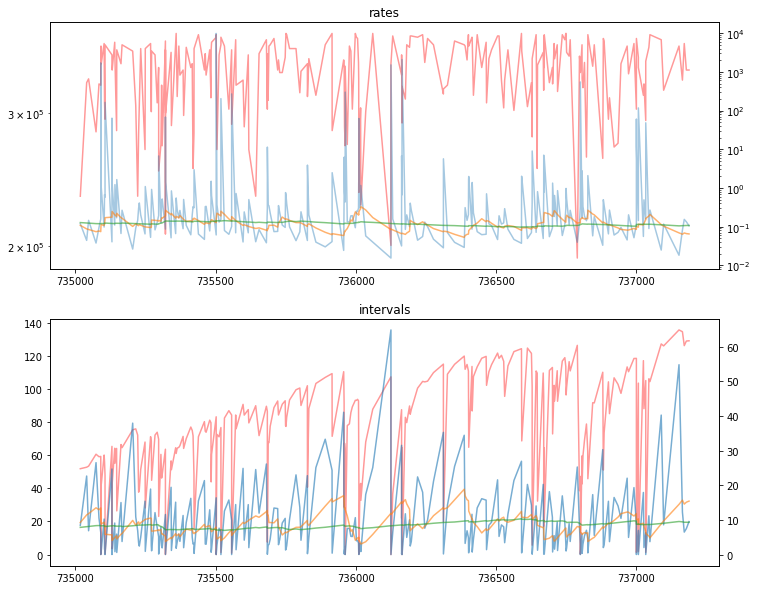

In [16]:
# Set up set(s) of ETAS-like, mean-interval, and mean-interval-GR sequences for comparison.
#
# time axis:
ts = rates.T[0]
# ETAS rates:
# "GR,Omori Moment Release Estimator Sequence" (GOMRES, pronounced, "GOMERS")?
rates = numpy.array(etas)
intervals_0 = 1./rates.T[1]
#
mean_intervals = {n:numpy.array([(t2-t1)/float(n) for t1,t2 in zip(ts[0:-n], ts[n:])]) for n in [1,10,100]}
mean_rates = {n:1./X for n,X in mean_intervals.items()}
#
#
# let's also look at a simlper scaled sequence, like the sigma() metric, based on GR scaling.
m0 = 3.0
n_grs = [10.**(m-m0) for m in etas.catalog['mag']]
intervals_GR = {n:numpy.array([(t2-t1)/numpy.sum(n_grs[k:k+n]) for k, (t1,t2) in enumerate(zip(ts[0:-n], ts[n:]))])
               for n in (1,10,100)}
rates_GR     = {n:Y/n for n,Y in intervals_GR.items()}
#
#
k_start = 250
#
print('etas rates: ')
print(rates[0:10])
print('\nmean_rates_10: ')
print(mean_rates[10][0:10])
plt.figure(figsize=(12,10))
ax1 = plt.subplot('211')
ax2 = plt.subplot('212')
#
#
ax1a = ax1
ax1a = ax1.twinx()
ax1.set_yscale('log')
ax1a.set_yscale('log')
ax1.set_title('rates')
ax2.set_title('intervals')

#
#ax1.plot(*zip(*rates[-k_start:]), ls='-', zorder=5, alpha=.4, color='r')
ax1.plot(*(rates[-k_start:]).T[0:3:2], ls='-', zorder=5, alpha=.4, color='r')
print(len(ts), len(rates))
#
# TODO: handle the sub-sequencing properly, so we don't over/under-run array lengths.
#
ax1a.plot(ts[-k_start:], mean_rates[1][-k_start:], alpha=.4)
ax1a.plot(ts[-k_start:], mean_rates[10][-k_start:], alpha=.6)
ax1a.plot(ts[-k_start:], mean_rates[100][-k_start:], alpha=.6)
#
ax2a = ax2.twinx()
#ax.set_yscale('log')
#axa = ax
#
ax2.plot(ts[-k_start:], intervals_0[-k_start:], ls='-', zorder=5, alpha=.4, color='r')
#print(len(ts), len(rates_1))
#
ax2a.plot(ts[-k_start:], mean_intervals[1][-k_start:], alpha=.6)

ax2a.plot(ts[-k_start:], mean_intervals[10][-k_start:], alpha=.6)
ax2a.plot(ts[-k_start:], mean_intervals[100][-k_start:], alpha=.6)

#
z0 = max(rates.T[1])
#ax1.set_ylim(-.1*z0, 1.5*z0)

ETAS rates smoothed: mean, median, stdev: 1366.1148720799079, 0.09683618546159725, 0.008444877801728173, 20050.032091742196
ETAS intervals smoothed: mean, median, stdev: 27.784393767055008, 10.326718922747414, 118.41497573776122, 52.29833700415066


intervals_GR:
mean/median/mode intervals[1]: 0.6522317870883314, 0.09184576290642393, 0.0, 1.4039420541423842
mean/median/mode rates[1]: 0.6522317870883314, 0.09184576290642393, 0.0, 1.4039420541423842
mean/median/mode intervals[10]: 0.3761918809542771, 0.202951984882963, 1.0431624241464322e-06, 0.48224136843370613
mean/median/mode rates[10]: 0.037619188095427705, 0.020295198488296303, 1.0431624241464322e-07, 0.04822413684337061
mean/median/mode intervals[100]: 0.23331780417694678, 0.18348874720013875, 1.8482901279598883e-05, 0.23537510849181179
mean/median/mode rates[100]: 0.002333178041769468, 0.0018348874720013875, 1.8482901279598882e-07, 0.002353751084918118


(0.0, 162.90205226492816)

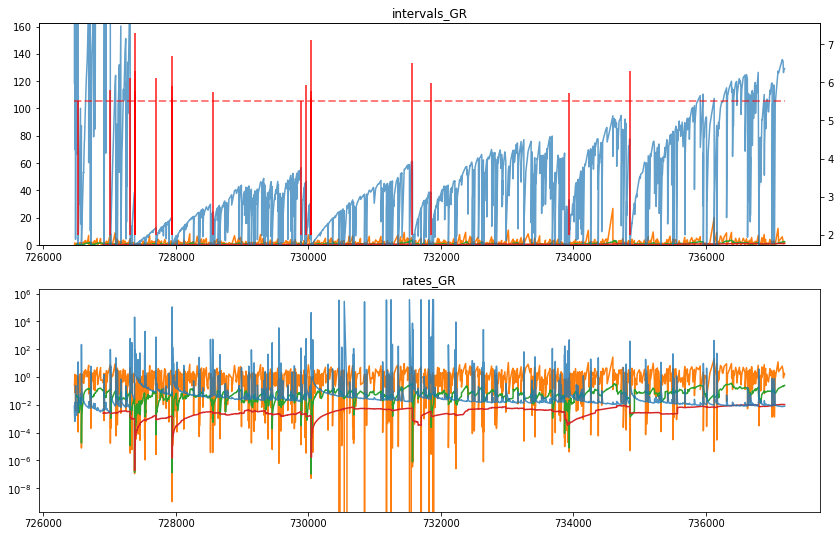

In [17]:
print('ETAS rates smoothed: mean, median, stdev: {}, {}, {}, {}'.format(numpy.mean(rates.T[1]), 
                                                numpy.median(rates.T[1]), scipy.stats.mode(rates.T[1])[0][0],
                                                numpy.std(rates.T[1])))

print('ETAS intervals smoothed: mean, median, stdev: {}, {}, {}, {}\n\n'.format(numpy.mean(intervals_0), 
                                                numpy.median(intervals_0), scipy.stats.mode(intervals_0)[0][0],
                                                        numpy.std(intervals_0)))
plt.figure(figsize=(14,9))
ax1 = plt.subplot('211')
ax1a = ax1.twinx()
ax2 = plt.subplot('212')
ax1.set_yscale('linear')
ax2.set_yscale('log')
ax1.set_title('intervals_GR')
ax2.set_title('rates_GR')
#
# TODO: need some pre-smoothing before Kalman. maybe a peaks (HH type) filter?
#K_intervals = kalman_filters.Kalman_Filter(intervals_0)
#
print('intervals_GR:')
ax1.plot(ts, intervals_0, ls='-', marker='', alpha=.7, zorder=10, label='etas')
#ax1.plot(ts, K_intervals.xs, ls='-', marker='', alpha=.8, zorder=11, label='etas', color='m')
# TODO: Note: we can also use the catalog['event_data_float'] column in etas.catalog -- which we should probably
#  do, instead of converting the datetimnes manually in script. we should also add functions to easily fetch
#  the time column, etc.
m0 = 5.5
t_m0, m_m0 = numpy.array([(t,m) for t,m in zip(ts, etas.catalog['mag']) if m>=m0]).T
#print('*** DEBUG: ', t_m0[0:5], m_m0[0:5])
ax1a.vlines(t_m0, ymin=2., ymax=m_m0, colors='r', lw=2., alpha=.7)
ax1a.plot(ts[0::len(ts)-1], [m0,m0], color='r', ls='--', alpha=.5, lw=2.0)


ax2.plot(ts, rates.T[1], ls='-', marker='', alpha=.8, zorder=11, label='etas')
for n,Y in intervals_GR.items():
    ax1.plot(ts[-len(Y):], Y, ls='-', label='{}'.format(n))
    ax2.plot(ts[-len(Y):], rates_GR[n], ls='-', label='{}'.format(n))
    print('mean/median/mode intervals[{}]: {}, {}, {}, {}'.format(n,numpy.mean(Y),numpy.median(Y),
                                                        scipy.stats.mode(Y)[0][0], numpy.std(Y)))
    
    print('mean/median/mode rates[{}]: {}, {}, {}, {}'.format(n,numpy.mean(rates_GR[n]),numpy.median(rates_GR[n]),
                                                     scipy.stats.mode(rates_GR[n])[0][0], numpy.std(rates_GR[n])))
    #
#

#
ax1.set_ylim(0., 1.2*numpy.max(intervals_0[-int(.5*len(intervals_0)):]))
#ax1.set_ylim(0., 1.1*numpy.max(intervals_0))
#ax1.set_ylim(0., 1.1*numpy.max(intervals_0))

In [18]:
#del intervals_prime

In [19]:
# take a look at the peak-filter sequence.

#print(etas.catalog.dtype)
#print('lens: ', len(etas.catalog), len(ts))

#print('***', K_intervals[0:5])
#

intervals_prime = Peak_Filter(numpy.array([ts, intervals_0]).T)
intervals_prime_4 = Peak_Filter(numpy.array([ts, intervals_0]).T, n_cycles=3)
#
# use this HHish sequence as a normalization factor:
j_start = numpy.argmin([(t,y) for t,y in zip(ts, intervals_0) if t<727800])
t_start = ts[j_start]
intervals_prime_5 = Peak_Filter((numpy.array([ts, intervals_0]).T)[j_start:], n_cycles=6)
intervals_env = numpy.copy(intervals_prime_5)
#intervals_env = numpy.append(intervals_env, [[ts[-1], intervals_env[-1][1]]], axis=0)

#
f_interp_envelope = scipy.interpolate.interp1d(*intervals_env.T, kind='linear', fill_value='extrapolate')
#,
#                                fill_value=(intervals_env[0][1], intervals_env[-1][1]))
#

print('*** DEBUG: ', t_m0[0:5], m_m0[0:5])
plt.figure(figsize=(10,8))
ax1 = plt.subplot('211')
ax1a = ax1.twinx()
ax2 = plt.subplot('212', sharex=ax1)
ax2a = ax2.twinx()
#
ax1.plot(ts, intervals_0, ls='-', zorder=2, alpha=.4)
#ax1.plot(K_intervals.xs, ls='-', marker='', alpha=.8, zorder=11, label='etas', color='m')
ax1.plot(*zip(*intervals_prime), ls='-', marker='', zorder=3, alpha=.4)
ax1.plot(*zip(*intervals_prime_4), ls='-', marker='', zorder=4, alpha=.9)
ax1.plot(*zip(*intervals_prime_5), ls='-', marker='', zorder=4, alpha=.9)
ax1a.vlines(t_m0, ymin=2., ymax=m_m0, colors='r', lw=2., alpha=.7)
#
#
ax1.set_ylim(.9*min(intervals_0[-int(.25*len(ts)):]), 1.1*max(intervals_0[-int(.25*len(ts)):]))
#
X_interp = intervals_prime_4.X[intervals_prime_4.X>t_start]
Y_env_interpolated = f_interp_envelope(X_interp)
Y = intervals_prime_4.Y[-len(X_interp):]
#
ax1.plot(*zip(*intervals_env), ls='--', marker='.')
#
#ax2.plot(X_interp, Y_env_interpolated, ls='-')
#ax2.plot(X_interp, Y, ls='--')
ax2.plot(X_interp, Y-Y_env_interpolated, ls='--')
ax2.plot(X_interp[0::len(X_interp)-1], [1., 1.], ls='--', color='k', alpha=.5, lw=2.)
ax2a.vlines(t_m0, ymin=2., ymax=m_m0, colors='r', lw=2., alpha=.7)


*** DEBUG: 0/1, len=2822
*** DEBUG: 0/3, len=2822
*** DEBUG: 1/3, len=753
*** DEBUG: 2/3, len=166
*** DEBUG: 0/6, len=2331
*** DEBUG: 1/6, len=631
*** DEBUG: 2/6, len=141
*** DEBUG: 3/6, len=33
*** DEBUG: 4/6, len=11
*** DEBUG: 5/6, len=3


ValueError: x and y arrays must have at least 2 entries



mean_intervals:
mean/median/mode interval[1]: 3.7996632122261023, 0.7614807870704681, 0.0, 6.822265966253583
mean/median/mode rates[1]: inf, 1.3132307695472547, inf, nan
mean/median/mode interval[10]: 3.7826242073380936, 3.18092182870605, 0.00078866898547858, 3.7068532181058895
mean/median/mode rates[10]: 30.542832888825224, 0.3143742807662766, 0.05155811598249769, 110.31469842428243
mean/median/mode interval[100]: 3.7120815856671534, 3.565006802662392, 0.00476239467621781, 2.7188066143285305
mean/median/mode rates[100]: 6.261645411116577, 0.2805043845741268, 0.09675875105547255, 22.5381699663785


/home/myoder/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


(0.0, 0.0018854404197329647)

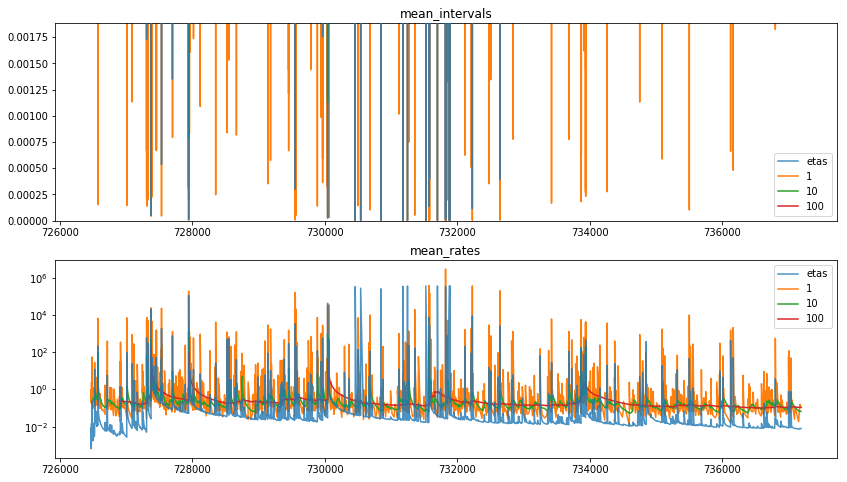

In [20]:
ax1.legend(loc=0)
ax2.legend(loc=0)

plt.figure(figsize=(14,8))
ax1 = plt.subplot('211')
ax2 = plt.subplot('212')
ax1.set_yscale('linear')
ax2.set_yscale('log')
ax1.set_title('mean_intervals')
ax2.set_title('mean_rates')

#
print('\n\nmean_intervals:')
ax1.plot(ts, intervals_0, ls='-', marker='', alpha=.8, zorder=11, label='etas')
ax2.plot(ts, rates.T[1], ls='-', marker='', alpha=.8, zorder=11, label='etas')
for n,Y in mean_intervals.items():
    ax1.plot(ts[-len(Y):], Y, ls='-', label='{}'.format(n))
    ax2.plot(ts[-len(Y):], mean_rates[n], ls='-', label='{}'.format(n))
    print('mean/median/mode interval[{}]: {}, {}, {}, {}'.format(n,numpy.mean(Y),numpy.median(Y),
                                                                 scipy.stats.mode(Y)[0][0], numpy.std(Y)))
    
    print('mean/median/mode rates[{}]: {}, {}, {}, {}'.format(n,numpy.mean(mean_rates[n]),numpy.median(mean_rates[n]),
                                                    scipy.stats.mode(mean_rates[n])[0][0], numpy.std(mean_rates[n])))
ax1.legend(loc=0)
ax2.legend(loc=0)#ax1.set_ylim(0., 1.1*numpy.max(intervals_0[-int(.25*len(intervals_0))]))
ax1.set_ylim(0., 1.2*numpy.max(intervals_0[-int(.5*len(intervals_0)):])/(3600.*24.))

#ax1.plot(ts[-len(Y):], Y, '-', label='$n=1$')

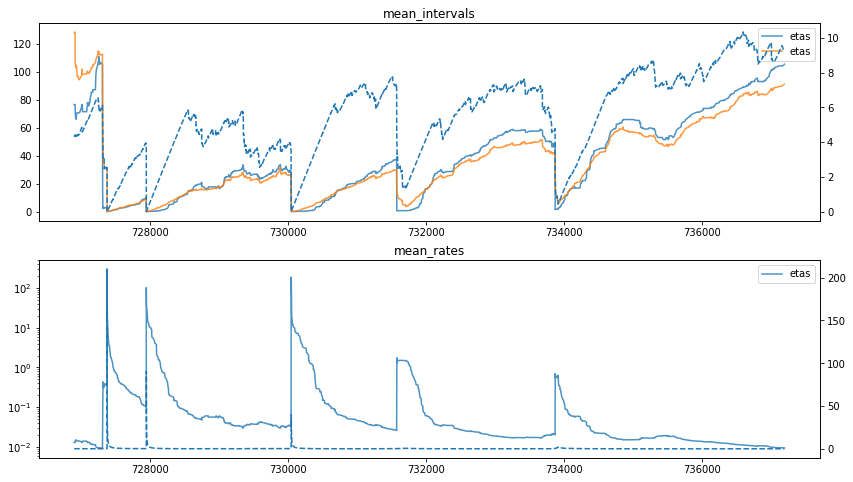

In [21]:
plt.figure(figsize=(14,8))
ax1 = plt.subplot('211')
ax2 = plt.subplot('212')
ax1.set_yscale('linear')
ax2.set_yscale('log')
ax1.set_title('mean_intervals')
ax2.set_title('mean_rates')

n_mean = 100
ax1.plot(ts[n_mean:], [numpy.median(intervals_0[k:k+n_mean]) for k,x in enumerate(intervals_0[n_mean:])],
         ls='-', marker='', alpha=.8, zorder=11, label='etas')
ax1.plot(ts[n_mean:], [numpy.mean(intervals_0[k:k+n_mean]) for k,x in enumerate(intervals_0[n_mean:])],
         ls='-', marker='', alpha=.8, zorder=11, label='etas')
#
ax1.twinx().plot(ts[-len(mean_intervals[100]):], mean_intervals[100], ls='--')

ax2.plot(ts[n_mean:], [numpy.median(rates.T[1][k:k+n_mean]) for k,x in enumerate(rates[n_mean:])],
         ls='-', marker='', alpha=.8, zorder=11, label='etas')
ax2.twinx().plot(ts[-len(mean_rates[100]):], mean_rates[100], ls='--')

ax1.legend(loc=0)
ax2.legend(loc=0)

### Using TensorFlow Keras Neural Nets...
- Build a Keras.Sequential() model
- With at least one LSTM layer
- For our first model, we will simply try to reproduce the sequence. The main idea being that we can forecast the expected rate of seismicity
- Note that for this model, the "X" inputs are the lag vector to "Y",
  - (X, Y)_k = (Y[k-n:k], Y_k)
  - We then salvage the time vector t_k separately

#### What comes next:
- Some front-matter, sorting out data, creating lag-matrix, separating training and test vectors, etc.
- Create a Sequential() model
- Plot data
- Predict() and plot more data...

#### General findings:
- We can model the sequence pretty well
- But what is this really telling us? We can estimate the interval $\Delta t_{k}$ from $\vec \Delta t_{k-n:k}$ pretty well. From that, maybe we can compute some GR based expected rates and probabilities.
- Can we train it more directly on the occurrence of earthquakes? Maybe an equation like,
\begin{equation}
[\Delta t, \Delta\Delta t]_{k-n:k} \cdot \vec{b} = \Delta t_m
\end{equation}

where $\Delta t_m$ is the expected interval to the next (large) event of magnitude $>m$?


** * lens: t[2551],Y_kal[2551])
***  (2148, 1, 10) (381, 1, 10) (2148,) (381,) (2159,) (392,) (2551,)


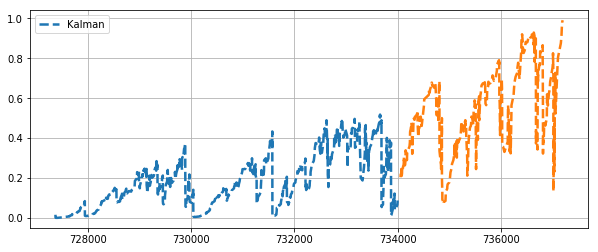

In [53]:
# Now, let's try a TF.Keras NN or two. what can we predict?
#
# use this (these) sequence(s):
#
#ints_sm = yodiipy.kalman_filters.Kalman_Filter(etas_mc35.intervals_pre, var_ba_factor=10.)
#ax2.plot(etas_mc35.X, ints_sm.xs, ls='--', lw=2.5, label='Kalman')
#
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append([a])
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)
#
k0 = 270
#
t_0 = etas_mc35.X[k0:]
Y_raw = etas_mc35.intervals_pre[k0:]
#Y_kal_0 = ints_sm.xs[k0:]
Y_kal_0 = yodiipy.kalman_filters.Kalman_Filter(etas_mc35.intervals_pre, var_ba_factor=1. ).xs[k0:]
#t = t_0
#Y_kal = Y_kal_0
#
# let's also apply some mean/median smoothing, like:
# t_smooth, X_smmoth = ts[n_mean:], [numpy.median(intervals_0[k:k+n_mean]) for k,x in enumerate(intervals_0[n_mean:])]
n_smooth = 1
t = t_0[n_smooth:]
Y_kal = numpy.array([numpy.median(Y_kal_0[k:k+n_smooth]) for k,x in enumerate(Y_kal_0[n_smooth:])])
#
print('** * lens: t[{}],Y_kal[{}])'.format(len(t), len(Y_kal)))
#
# use this scalar object to nornmalize sequences.
scaler = MinMaxScaler(feature_range=(0, 1))
Y_raw = scaler.fit_transform(Y_raw.reshape(-1,1))
Y_kal = scaler.fit_transform(Y_kal.reshape(-1,1))
#
#ax1.plot(etas_mc35.X[k0:], etas_mc35.intervals_pre[k0:], label='mc35 data')
#ax1.plot(etas_mc35.X[k0:], ints_sm.xs[k0:], ls='--', lw=2.5, label='Kalman')
#
# Set up some prams and subsets for a NN
ix_tr = t<734000.
ix_tst = numpy.invert(ix_tr)
#
t_tr = t[ix_tr]
t_tst = t[ix_tst]
look_back = 10
#
X_tr, Y_tr   = create_dataset(Y_kal[ix_tr], look_back=look_back)
X_tst, Y_tst = create_dataset(Y_kal[ix_tst], look_back=look_back)
print('*** ', X_tr.shape, X_tst.shape, Y_tr.shape, Y_tst.shape,t_tr.shape, t_tst.shape, t.shape)
#print('*** ', X_tr[0:5], Y_tr[0:5])
#
fg = plt.figure(figsize=(10,4))
ax1 = plt.subplot('111')
ax1.grid()
#
#ax1.plot(X, Y_raw, label='mc35 data', alpha=.4)
#ax1.plot(X, Y_kal, ls='--', lw=2.5, label='Kalman')
#
ax1.plot(t_tr[-len(Y_tr):], Y_tr, ls='--', lw=2.5, label='Kalman')
ax1.plot(t_tst[-len(Y_tst):], Y_tst, ls='--', lw=2.5)
#
ax1.legend(loc=0)
#ax1.set_yscale('log')


In [61]:
#print('shapes: ', X_tr.shape, Y_kal_tr.shape)
#

model = Sequential()
# we can add a convolutional layer here, but it's not clear if it gets us anything.
#  might be more useful in a (x,dx)*b = dt_m model.
model.add(keras.layers.Conv1D(filters=32, kernel_size=20, padding='same', activation='relu', input_shape=(1, look_back)))
model.add(keras.layers.MaxPooling1D(pool_size=1))
#model.add(LSTM(32, input_shape=(1, look_back)))
model.add(LSTM(32))
#
model.add(keras.layers.Dropout(.1))
#model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
#model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
model.fit(X_tr, Y_tr, epochs=100, batch_size=128, verbose=False)
#

print(model.summary())
#
print('Eval: {}, {}'.format(X_tr.shape, Y_tr.shape))
xx = model.evaluate(X_tst, Y_tst)
#
print('** xx: ', xx)
#
train_predict = model.predict(X_tr)
test_predict = model.predict(X_tst)
#
print('shapes: ', train_predict.shape, test_predict.shape)
#

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 1, 32)             3232      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 1, 32)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 11,585
Trainable params: 11,585
Non-trainable params: 0
_________________________________________________________________
None
Eval: (2148, 1, 10), (2148,)
381/381 [==============================] - 1s 1ms/step
** 

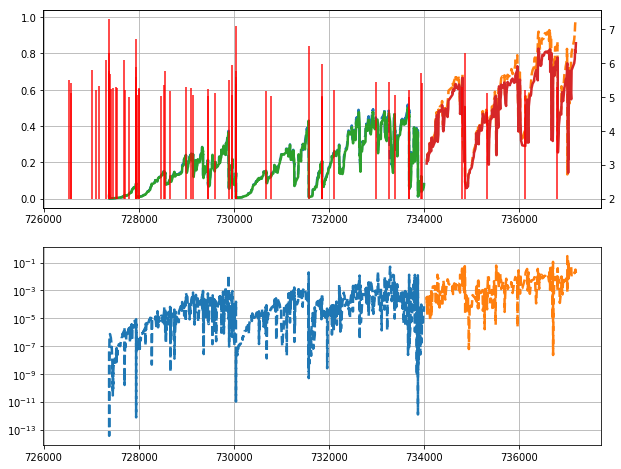

In [62]:
#
fg = plt.figure(figsize=(10,8))
ax1 = plt.subplot('211')
ax1a = ax1.twinx()
ax2 = plt.subplot('212', sharex=ax1)
ax1.grid()
ax2.grid()
#
#ax1.plot(X, Y_raw, label='mc35 data', alpha=.4)
#ax1.plot(X, Y_kal, ls='--', lw=2.5, label='Kalman')
#
ax1.plot(t_tr[-len(Y_tr):], Y_tr, ls='--', lw=2.5, label='Kalman')
ax1.plot(t_tst[-len(Y_tst):], Y_tst, ls='--', lw=2.5, label='Kalman')
#
t_m0, m_m0 = numpy.array([(t,m) for t,m in zip(ts, etas.catalog['mag']) if m>=5]).T
#print('*** DEBUG: ', t_m0[0:5], m_m0[0:5])
ax1a.vlines(t_m0, ymin=2., ymax=m_m0, colors='r', lw=2., alpha=.7)
#
#ax1.set_xlim(734000)
ax2.set_yscale('log')
#
ax1.plot(t_tr[-len(train_predict):], train_predict[:,0], ls='-', lw=2.5, label='tr_pr')
ax1.plot(t_tst[-len(test_predict):], test_predict[:,0], ls='-', lw=2.5, label='tst_pr')
#
res_pr = (train_predict[:,0] - Y_tr)**2.
res_tst = (test_predict[:,0] - Y_tst)**2.
ax2.plot(t_tr[-len(res_pr):], res_pr, ls='--', lw=2.5, label='tr_pr')
ax2.plot(t_tst[-len(res_tst):], res_tst, ls='--', lw=2.5, label='tst_pr')
#

No handles with labels found to put in legend.


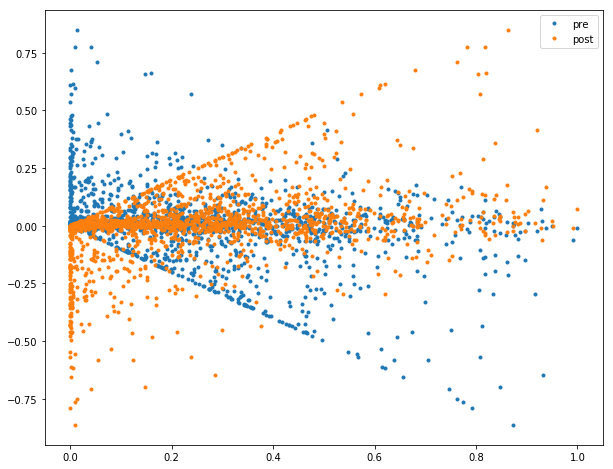

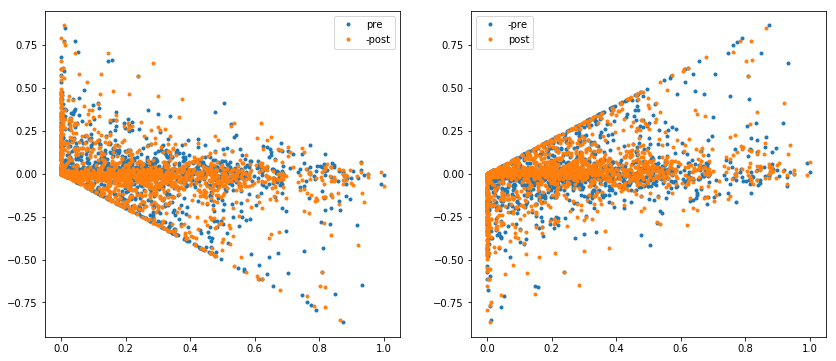

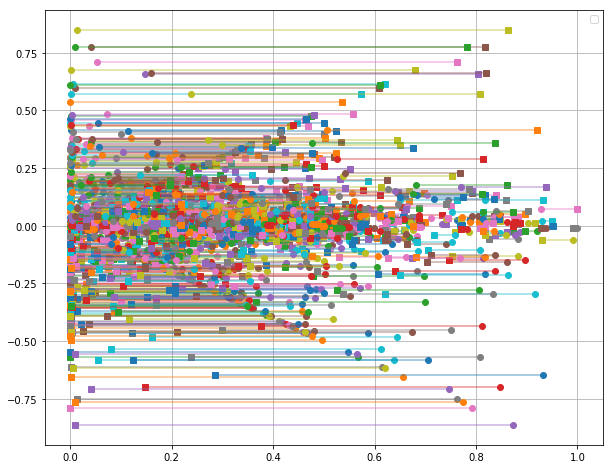

In [63]:
#ax2.plot(t_tr[1:], numpy.diff(Y_kal_tr[:,0])/numpy.diff(t_tr), ls='--', lw=2.5, label='Kalman')
#ax2.plot(t_tst[1:], numpy.diff(Y_kal_tst[:,0])/numpy.diff(t_tst), ls='--', lw=2.5)
#
fg = plt.figure(figsize=(10,8))
ax = plt.gca()
ax.grid()
deltas = numpy.diff(Y_raw[:,0])
ax.plot(Y_raw[0:-1], deltas, ls='', marker='.', label='pre')
ax.plot(Y_raw[1:], deltas, ls='', marker='.', label='post')
ax.legend(loc=0)
#
# these two plots (Y_raw[0:-1] and Y_raw[1:] look very symmetrical -- and are probably statistically
#  symmetrical, but this a bit of an illusion. if you look at the next (now, next-next) figure,
#  you can see that the points on the slope (that basically show the apparent symmetry) don't flip sign, 
#  as appears to be the case -- intuitively, but are shifted along the x-axis in a way that creates
#  an apparent symmetry about the x-axis (in the y-direction). We'll have a closer look at that by plotting
#  Y_raw[0:-1] and -Y_raw[0:-1] (and same for Y_raw[1:]).
fg = plt.figure(figsize=(14,6))
ax1 = plt.subplot('121')
ax2 = plt.subplot('122')
ax.grid()
#deltas = numpy.diff(Y_raw[:,0])
ax1.plot(Y_raw[0:-1], deltas, ls='', marker='.', label='pre')
ax2.plot(Y_raw[0:-1], -deltas, ls='', marker='.', label='-pre')
ax2.plot(Y_raw[1:], deltas, ls='', marker='.', label='post')
ax1.plot(Y_raw[1:], -deltas, ls='', marker='.', label='-post')
ax1.legend(loc=0)
ax2.legend(loc=0)

#
fg = plt.figure(figsize=(10,8))
ax = plt.gca()
ax.grid()
#
deltas = numpy.diff(Y_raw[:,0])
for x1,x2,y in zip(Y_raw[0:-1], Y_raw[1:], deltas):
    ln, = ax.plot([x1,x2], [y,y], ls='-', alpha=.5)
    clr=ln.get_color()
    ax.plot([x1], [y], 'o', color=clr)
    ax.plot([x2], [y], 's', color=clr)
#ax.plot(Y_raw[0:-1], deltas, ls='', marker='.', label='pre')
#ax.plot(Y_raw[1:], deltas, ls='', marker='.', label='post')
ax.legend(loc=0)

/home/myoder/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


ValueError: supplied range of [0.011553670044144192, inf] is not finite

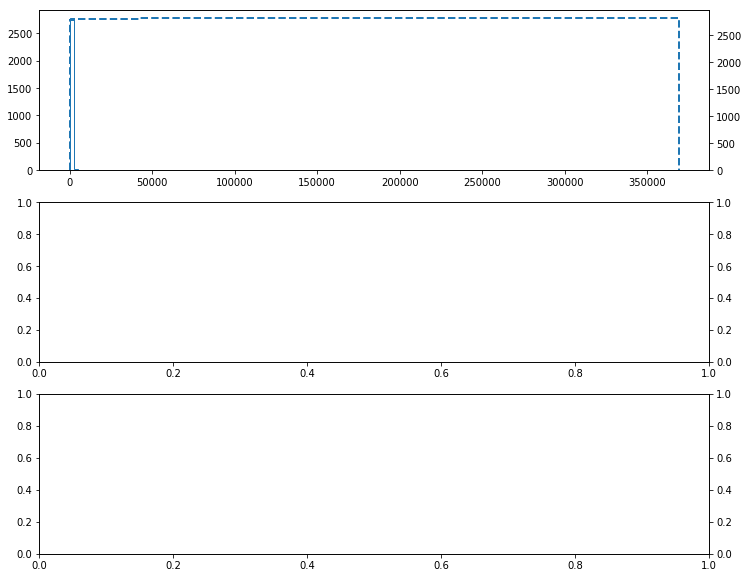

In [46]:
# FIXME:
# TODO: Figure out all of this broken stuff...
#
# let's have a look at the variable magnitude distributions for each of the three sequence types.
fg = plt.figure(figsize=(12,10))
ax1 = plt.subplot('311')
ax1a = ax1.twinx()
ax2 = plt.subplot('312')
ax2a = ax2.twinx()
ax3 = plt.subplot('313')
ax3a = ax3.twinx()
#
n_pdf = 150
h = ax1.hist(rates.T[1], n_pdf, label='ETAS_rates', histtype='step')
h = ax1a.hist(rates.T[1], n_pdf, label='ETAS_rates', histtype='step', cumulative=True,
               lw=2., ls='--')


for n,X in mean_rates.items():
    h=ax2.hist(X, n_pdf, label='mean_rates[{}]'.format(n), histtype='step', log=True, normed=True)
    h=ax2a.hist(X, n_pdf, label='mean_rates[{}]'.format(n), histtype='step', log=True, normed=True, cumulative=True,
               lw=2., ls='--')
#
for n,X in rates_GR.items():
    h=ax3.hist(X, n_pdf, label='GR_rates[{}]'.format(n), histtype='step', log=True, normed=True)
    h=ax3a.hist(X, n_pdf, label='GR_rates[{}]'.format(n), histtype='step', log=True, normed=True, cumulative=True,
               lw=2., ls='--')
# 
ax1.set_title('ETAS')
ax2.set_title('mean_rates')
ax3.set_title('mean_rates_GR')

/home/myoder/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


ValueError: supplied range of [0.0, inf] is not finite

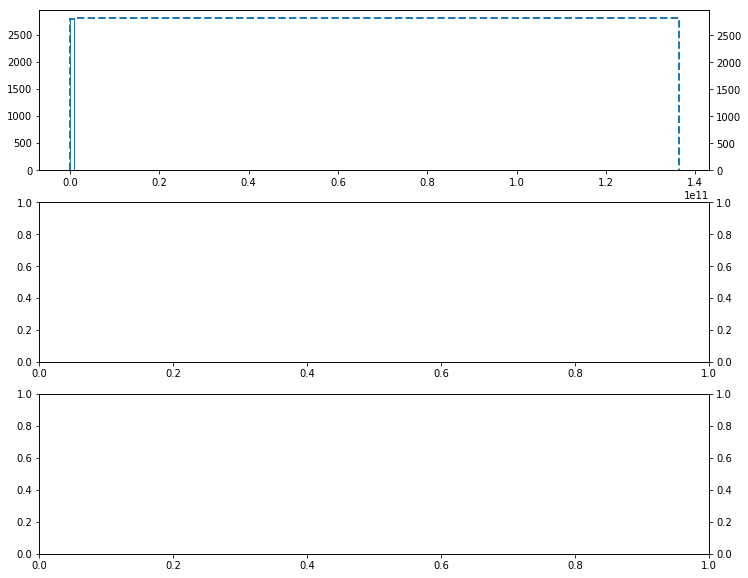

In [28]:
# now let's have a look at the variance (about the mean... but let's use the median)
#  distributions for each of the three sequence types.
fg = plt.figure(figsize=(12,10))
ax1 = plt.subplot('311')
ax1a = ax1.twinx()
ax2 = plt.subplot('312')
ax2a = ax2.twinx()
ax3 = plt.subplot('313')
ax3a = ax3.twinx()
#
n_pdf = 150
def minus_median(X):
    return (numpy.array(X)-numpy.median(X))**2.
h = ax1.hist(minus_median(rates.T[1]), n_pdf, label='ETAS_rates', histtype='step')
h = ax1a.hist(minus_median(rates.T[1]), n_pdf, label='ETAS_rates', histtype='step', cumulative=True,
               lw=2., ls='--')


for n,X in mean_rates.items():
    h=ax2.hist(minus_median(X), n_pdf, label='mean_rates[{}]'.format(n), histtype='step', log=True, normed=True)
    h=ax2a.hist(minus_median(X), n_pdf, label='mean_rates[{}]'.format(n), histtype='step', log=True, normed=True, cumulative=True,
               lw=2., ls='--')
#
for n,X in rates_GR.items():
    h=ax3.hist(minus_median(X), n_pdf, label='GR_rates[{}]'.format(n), histtype='step', log=True, normed=True)
    h=ax3a.hist(minus_median(X), n_pdf, label='GR_rates[{}]'.format(n), histtype='step', log=True, normed=True, cumulative=True,
               lw=2., ls='--')
# 
ax1.set_title('ETAS')
ax2.set_title('mean_rates')
ax3.set_title('mean_rates_GR')

In [ ]:
# now, let's plot some earthquakes...

fg = plt.figure(figsize=(12,6))
ax1 = plt.subplot('211')
ax2 = plt.subplot('212')
#
ax1.plot(ts, rates.T[1])
ax2.plot(ts, etas.catalog['mag'], '.-')

fg=plt.figure(figsize=(11,6))
ax1 = plt.subplot('121')
ax2 = plt.subplot('122')
n_start=500
ax1.plot(etas.catalog['mag'][n_start:], rates.T[1][n_start:], ls='', marker='.')
ax1.plot(etas.catalog['mag'][n_start:], rates.T[2][n_start:], ls='', marker='.')

#ax1.plot(etas.catalog['mag'][1+n_start:], rates.T[1][n_start:-1], ls='', marker='.', alpha=.4)
#ax1.plot(etas.catalog['mag'][2+n_start:], rates.T[1][n_start:-2], ls='', marker='.', alpha=.4)
ax1.set_title('rate vs mag')
ax1.set_ylabel('rate')
ax1.set_xlabel('mag')
#
ax2.plot(etas.catalog['mag'][n_start:], intervals_0[n_start:], ls='', marker='.')
ax2.plot(etas.catalog['mag'][n_start:], 1./(rates.T[2][n_start:]), ls='', marker='.')
#ax2.plot(etas.catalog['mag'][1+n_start:], intervals_0[n_start:-1], ls='', marker='.', alpha=.4)
#ax2.plot(etas.catalog['mag'][2+n_start:], intervals_0[n_start:-2], ls='', marker='.', alpha=.4)
ax2.set_title('intervals vs mag')
ax2.set_ylabel('intervals')
ax2.set_xlabel('mag')

fg=plt.figure(figsize=(8,6))
ax = plt.gca()
n=1
ax.plot(*zip(*[[m,r] for m,r in zip(etas.catalog['mag'][n:], rates.T[1][:-n]) if m>5.]), ls='', marker='.') 


In [ ]:
# what do the variance distributions look like?
# basically, but mean-differencing over 10 or 100 give a very similar
#  mean variance with quyalitatively simlar distributions. variance on the ETAS based model is much closer to
#  being zero-centered.
#
diff_rms = numpy.sqrt((rates.T[1]-numpy.mean(rates.T[1]))**2.)
diff_rms1 = numpy.sqrt((rates_1-numpy.mean(rates_1))**2.)

int_diff_rms  = numpy.sqrt((intervals_0 - numpy.mean(intervals_0))**2.)
int_diff_rms1 = numpy.sqrt((intervals_1 - numpy.mean(intervals_1))**2.)
int_diff_rms10 = numpy.sqrt((intervals_10 - numpy.mean(intervals_10))**2.)
int_diff_rms100 = numpy.sqrt((intervals_100 - numpy.mean(intervals_100))**2.)

plt.figure()
plt.plot(int_diff_rms1)

do_log=True
plt.figure()
h = plt.hist(int_diff_rms, 250,normed=True, log=do_log)

plt.figure()
h = plt.hist(int_diff_rms1, 250,normed=True, log=do_log)

#plt.figure()
h = plt.hist(int_diff_rms10, 250,normed=True, log=do_log)

#plt.figure()
h = plt.hist(int_diff_rms100, 250,normed=True, log=do_log)

NameError: name 'diff_rms' is not defined

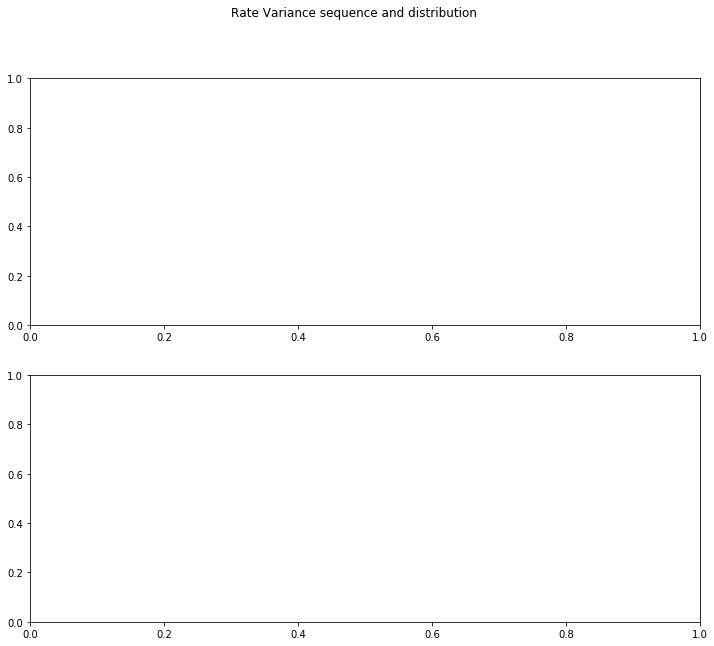

In [24]:
#
plt.figure(figsize=(12,10))
plt.suptitle('Rate Variance sequence and distribution')

ax1 = plt.subplot('211')
ax2 = plt.subplot('212')
#
ax1.plot(rates.T[0], diff_rms, '-')
#ax1.plot(rates.T[0][1:], diff_rms1, '-')
#
hh = ax2.hist(diff_rms, 250, normed=True)
#
#hh1 = ax2.hist(diff_rms1, 250, normed=True)

ax2.set_xlim(0., 4)

#
plt.figure(figsize=(12,10))
plt.suptitle('Interval Variance sequence and distribution')
ax1 = plt.subplot('211')
ax2 = plt.subplot('212')
ax2a = ax2.twinx()
#
ax1.plot(rates.T[0], int_diff_rms, '-')
ax1.plot(rates.T[0][1:], int_diff_rms1, '-')
#
hh = ax2.hist(int_diff_rms, 250, normed=True, color='b', alpha=.6)
#
hh1 = ax2a.hist(int_diff_rms1, 250, normed=True, color='r', alpha=.6)

# TODO: do this dynamically by finding the point of x% variance.

#ax2.set_xlim(0., .05)

### Interval and rate distributions
- double-triple check the codes on this, but what appears to be interesting is that the ETAS sequence produces exactly the opposite rate profile. definitely much less variability, but it actually seemst to suggest some sort of most likely mean rate >>0, and then a <<that probabiility of significantly higher rates.
- ... but mostly it is interesting because the rate probability distribution is opposite from binning.
- TODO: check out the cumulative distributions.


NameError: name 'rates_10' is not defined

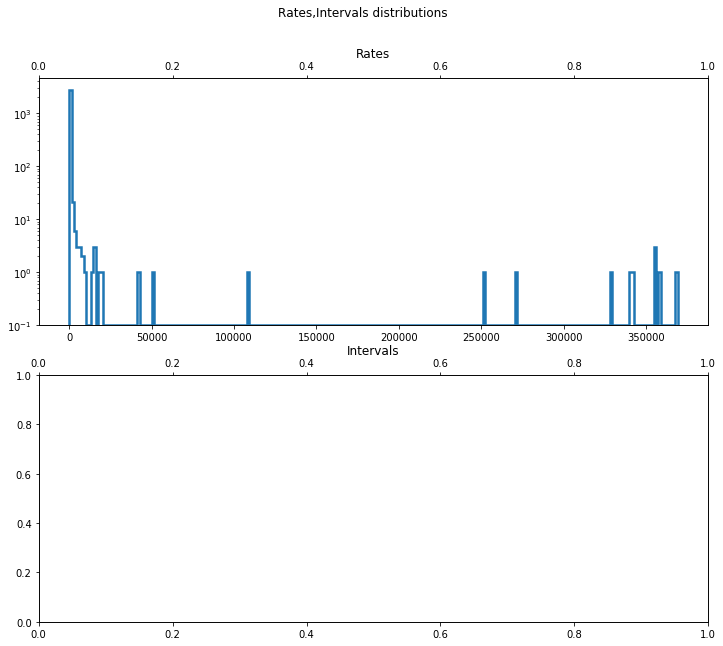

In [29]:
## What about just the distribution of the invervals or rates?
#
plt.figure(figsize=(12,10))
plt.suptitle('Rates,Intervals distributions')

ax1 = plt.subplot('211')
ax1a = ax1.twiny()
ax1.set_title('Rates\n')
ax2 = plt.subplot('212')
ax2a = ax2.twiny()
#ax2a = ax2
#ax1a = ax1
ax2.set_title('Intervals\n')
#
n=250
do_log=True
h = ax1.hist(rates.T[1], n, histtype='step', log=do_log, lw=2.5)
#h = ax1a.hist(rates_1,n, histtype='step', log=do_log)
h = ax1a.hist(rates_10,n, histtype='step', log=do_log)
h = ax1a.hist(rates_100,n, histtype='step', log=do_log)

h = ax2.hist(intervals_0, int(n/2), histtype='step', log=do_log, lw=2.5)
#h = ax2a.hist(intervals_1,n, histtype='step', log=do_log)
h = ax2a.hist(intervals_10,n, histtype='step', log=do_log)
h = ax2a.hist(intervals_100,n, histtype='step', log=do_log)

#plt.figure(figsize=(12,10))
#plt.suptitle('Intervals distributions')
#
#ax1 = plt.subplot('211')
#ax2 = plt.subplot('212')
#ax1.set_xlim(0., 200)

In [ ]:
print(etas.catalog[0:5])
print(etas.catalog.dtype.descr)
print('days_to_secs: ', gep.days2secs)
print('len: ',len(etas.catalog))